# Lesson 4B: Cart Controller (Pole + Cart Stabilization)

This notebook is designed to run in Google Colab or local Jupyter.

**Colab steps:** Open the notebook, run the setup cell below, then run cells top-to-bottom.

## Learning Objectives
- Design a cascaded controller for pole angle and cart position.
- Handle setpoint changes without destabilizing the pole.
- Assess tradeoffs between cart motion and pole stability.

### Parameters (update as needed)
| Symbol | Meaning | Example |
| --- | --- | --- |
| m_c | Cart mass | 0.5 kg |
| m_p | Pendulum mass | 0.2 kg |
| l | Pendulum length | 0.3 m |
| g | Gravity | 9.81 m/s^2 |
| dt | Sample time | 0.01 s |

---
## Lesson Content

In [1]:
# Install required packages (Colab)
!pip -q install numpy scipy matplotlib


## Integral action and drift
Start with a tuned P/PD controller, then add a constant bias or disturbance.

Tasks:
- Show steady-state error under bias.
- Add integral action to remove bias.
- Demonstrate how too much I destabilizes the system or causes windup.

Deliverable: a tradeoff table and tuning rationale.


# Implement a Control Strategy (Pole + Cart Stabilization)



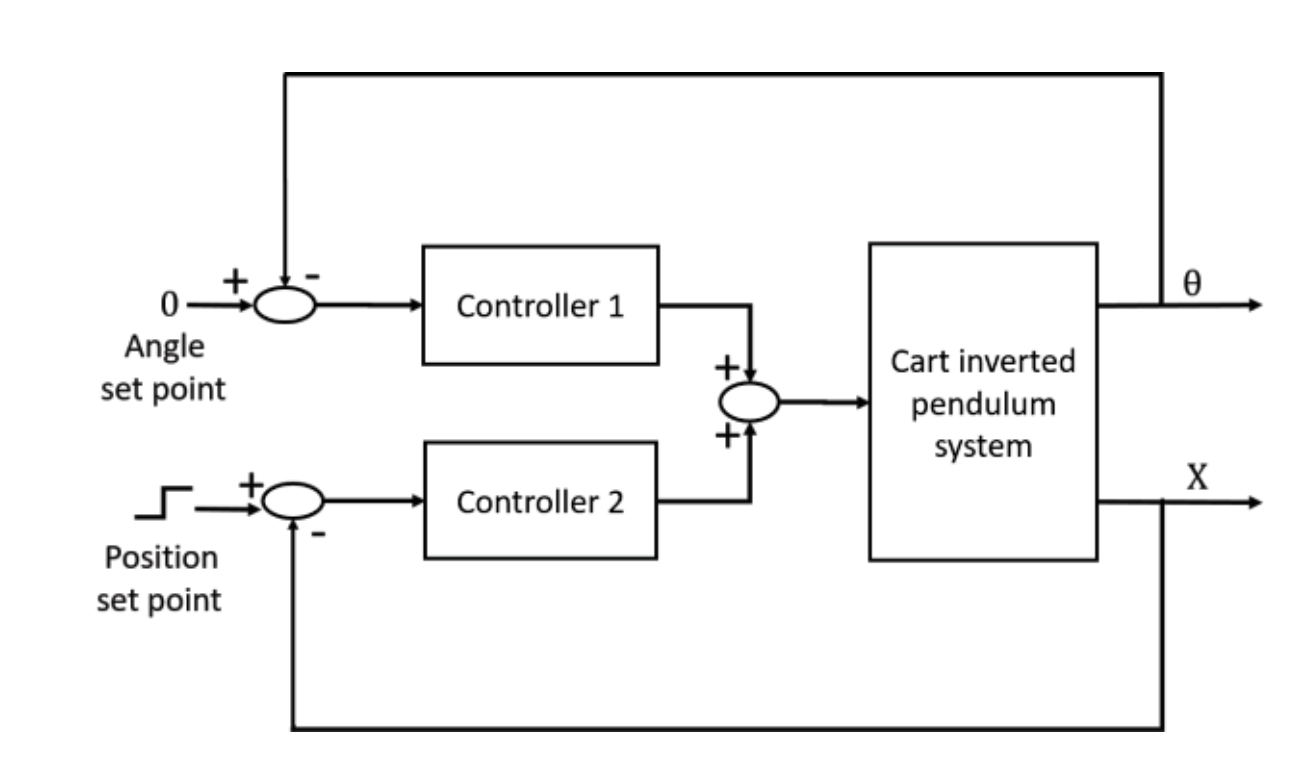

## Task: Implement Cascaded Control to control both pole angle and cart position
- Tune the cascade control system to control both desired set points.


### Cascaded controller example (cart position -> pole angle -> force)
This example implements a simple outer-loop position controller that generates a pole-angle setpoint, then an inner-loop PD controller that stabilizes the pole.


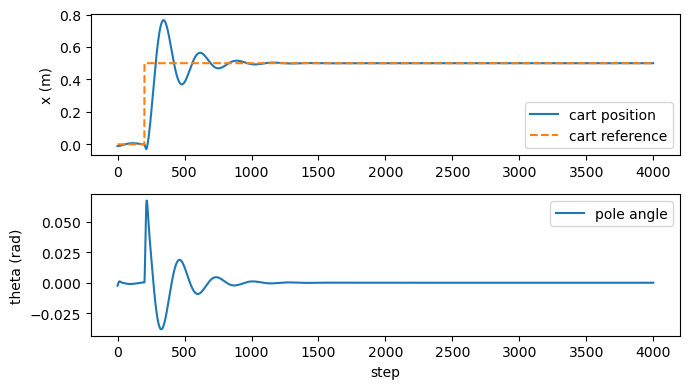

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

class InvertedPendulum:
    def __init__(self, dt=0.02):
        self.gravity = 9.8
        self.mass_cart = 1.0
        self.mass_pole = 0.1
        self.length = 0.5
        self.dt = dt
        # Small viscous damping to prevent energy growth
        self.cart_damping = 0.05
        self.pole_damping = 0.02
        self.state = np.zeros(4)

    def reset(self):
        self.state = np.random.uniform(low=-0.02, high=0.02, size=(4,))
        return self.state

    def step(self, force):
        x, x_dot, theta, theta_dot = self.state
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)

        x_acc = (force + self.mass_pole * sin_theta * (self.length * theta_dot**2 - self.gravity * cos_theta)) / (
            self.mass_cart + self.mass_pole * sin_theta**2
        )
        theta_acc = (-1 * force * cos_theta - self.mass_pole * self.length * theta_dot**2 * sin_theta * cos_theta +
                     (self.mass_cart + self.mass_pole) * self.gravity * sin_theta) / (
            self.length * (self.mass_cart + self.mass_pole * sin_theta**2)
        )

        # Simple viscous damping terms
        x_acc -= self.cart_damping * x_dot
        theta_acc -= self.pole_damping * theta_dot

        x += self.dt * x_dot
        x_dot += self.dt * x_acc
        theta += self.dt * theta_dot
        theta_dot += self.dt * theta_acc

        self.state = np.array([x, x_dot, theta, theta_dot])
        return self.state

# Controller gains (tune these)
kp_x = 0.1
kd_x = 0.05
kp_theta = 60.0
kd_theta = 8.0

# Simulation setup
pendulum = InvertedPendulum(dt=0.02)
state = pendulum.reset()

steps = 4000
T = steps * pendulum.dt

x_ref = 0.0
x_ref_final = 0.5
step_time = 4.0

states = np.zeros((steps, 4))
forces = np.zeros(steps)
refs = np.zeros(steps)

for k in range(steps):
    t = k * pendulum.dt
    if t > step_time:
        x_ref = x_ref_final

    x, x_dot, theta, theta_dot = state

    # Outer loop: cart position -> desired pole angle
    theta_ref = kp_x * (x_ref - x) + kd_x * (0.0 - x_dot)
    theta_ref = np.clip(theta_ref, -0.1, 0.1)  # limit tilt

    # Inner loop: pole angle -> force
    force = -(kp_theta * (theta_ref - theta) + kd_theta * (0.0 - theta_dot))
    force = np.clip(force, -10.0, 10.0)

    state = pendulum.step(force)

    states[k] = state
    forces[k] = force
    refs[k] = x_ref

# Plot cart position and pole angle
plt.figure(figsize=(7, 4))
plt.subplot(2, 1, 1)
plt.plot(states[:, 0], label='cart position')
plt.plot(refs, '--', label='cart reference')
plt.ylabel('x (m)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(states[:, 2], label='pole angle')
plt.ylabel('theta (rad)')
plt.xlabel('step')
plt.legend()

plt.tight_layout()
plt.show()


## Task: Changing Set point for cart position
- Simulate the system and observe how well it tracks the changing set point.

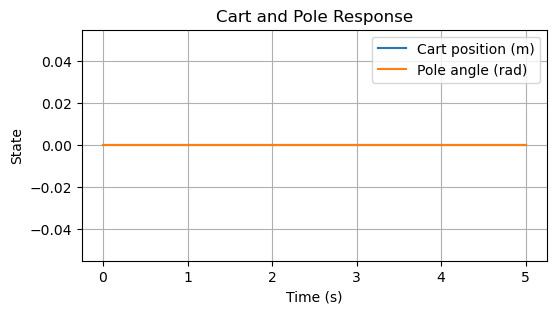

In [3]:
# Plot template for cart position and pole angle (replace with your data)
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 5, 501)
cart_pos = np.zeros_like(t)  # replace with your cart position data (m)
pole_angle = np.zeros_like(t)  # replace with your pole angle data (rad)

plt.figure(figsize=(6, 3))
plt.plot(t, cart_pos, label='Cart position (m)')
plt.plot(t, pole_angle, label='Pole angle (rad)')
plt.title('Cart and Pole Response')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.grid(True)
plt.show()


**Expected output:**
- Cart position tracks the setpoint while pole angle stays near 0 rad with minimal overshoot.

## Prediction -> simulate -> explain
Predict the effect of adding a bias disturbance before you run it. After running, explain why the steady-state error appears.


---
## Checkpoints
- Both cart position and pole angle track their targets.
- Setpoint changes do not cause instability.

## Common Pitfalls
- Overly aggressive inner-loop gains causing oscillations.
- Neglecting actuator limits during setpoint changes.